<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# tf中的多项分布

tf.random.categorical实现了多项分布的采样，其输入通常是神经网络的输出，详情可以参见：https://stackoverflow.com/questions/55063120/can-anyone-give-a-tiny-example-to-explain-the-params-of-tf-random-categorical

此方法替代了过时的multinomial方法。

本文运行于tensorflow 1.13版本。

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

tf.log 等价与 tf.math.log

In [2]:
logits = tf.log([[10., 10., 10., 10.]])
num_samples = 10
cat = tf.random.categorical(logits, num_samples)
cat

<tf.Tensor: id=3, shape=(1, 10), dtype=int64, numpy=array([[3, 1, 1, 0, 3, 3, 2, 3, 3, 2]])>

**结果解读**

tf.random.categorical和one-hot编码有非常相似的设计思路。上面的logits是一个4维向量，表示4个类别(class)的概率，即一次实验可能的4种情况发生的概率。[10.,10.,10.,10]表示这4个类别的概率（未正则化）是相同的，那么当采样10次（num_samples)时，每次采样出现0,1,2,3种类别（情况）的概率是相同的，因此在结果中0-3在每个位置上是随机的。

也就是说，结果给出的是每次采样到的类别，使用编号0-3表示。

In [3]:
logits = tf.log([[10., 10., 10., 10.],
                [0.,1.,2.,3.]])
num_samples = 20
cat = tf.random.categorical(logits, num_samples)
cat

<tf.Tensor: id=8, shape=(2, 20), dtype=int64, numpy=
array([[2, 1, 3, 2, 2, 0, 2, 0, 0, 2, 3, 1, 0, 0, 0, 2, 1, 1, 1, 0],
       [2, 3, 2, 3, 2, 3, 1, 2, 1, 1, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3]])>

**结果解读**

重点关注logits的第二行[0.,1.,2.,3.]，表示4个类别（情况）中，1号类别不可能出现，3号类比出现的概率是2号类别的2倍，4号类别出现的概率是1号类别的3倍。因此，当采样10次时可以发现，0在各个位置都不会出现，3出现的几率最高。

可视化参加下图，基本上符合logits中定义的概率分布。

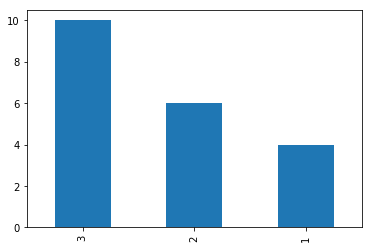

In [12]:
import pandas as pd
pd.value_counts(cat[1,:].numpy()).plot.bar()

In [5]:
r = tf.random.normal([2,4])
print(r)

tf.Tensor(
[[ 0.95217156 -0.08657972 -0.5858826   0.6170592 ]
 [ 0.10575847 -0.6206924  -0.7099539   1.0342921 ]], shape=(2, 4), dtype=float32)


In [6]:
logits = tf.log(r)
tf.random.categorical(logits,1)

<tf.Tensor: id=24, shape=(2, 1), dtype=int64, numpy=
array([[0],
       [3]])>

**结果解读**

可以看出，当从logits只采样1次的时候，`tf.random.categorical`实际上等同与做了`argmax`操作（不完全相同，argmax总是会返回最大概率的索引，但是categorical是个概率问题）：返回了最大概率的索引，这正是神经网络中最常见的使用方式。

需要注意的是，`tf.random.categorical(logits,1)`返回的是一个shape为(logits.shape[0],1)的张量，因此如果需要得到最后一行（通常是预测值）标量的索引，需要进一步的这样操作：

In [7]:
tf.random.categorical(logits,1)[-1,0].numpy()

3

# 二项分布
tensorflow的API设计在这里有点怪异，居然在tf.random包中找不到binomial方法。看一下numpy的API设计，在random包中整齐的排列了各种分布函数。

一个二项分布的例子：n为实验次数，p为正例概率，size为采样个数。当size=1时表示生成（采用）一个随机数，其值在0-10之间，并且在7附件的概率高。多次执行，会发现每次执行的结果不一样。

In [8]:
a = np.random.binomial(n=10, p=0.7, size=100)
a

array([ 6,  9,  4,  5,  6,  5,  5,  9,  8,  7,  5,  8,  8,  7,  8,  7,  7,
        7,  8,  7,  7,  8,  5,  6,  8,  8,  5,  9,  6,  5,  7,  7,  8,  6,
        5,  7,  5,  9,  9, 10,  8,  8,  8,  7,  7,  9,  8,  7,  7,  9,  8,
        6,  7,  8,  7,  7,  4,  7,  6,  7,  8,  5,  9,  9,  8,  3,  6,  4,
        6,  9,  7,  9,  7,  3,  9,  7,  6, 10,  6,  8,  6,  7,  8,  8, 10,
        5,  6,  6,  8,  6,  9,  8, 10,  9, 10,  6,  7,  8,  6,  5])

可视化，惊讶于pandas居然支持直接绘图！当然，要绘制更加复杂的图形，估计还得直接拿起matplotlib或者seaborn。

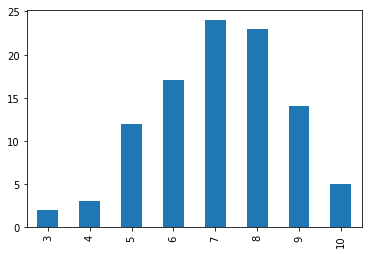

In [9]:
import pandas as pd
c = pd.value_counts(a) # 统计a中个元素出现的次数，也可以使用collections.Counter，但是不如pandas给出的结果直观
c.sort_index().plot.bar() # pandas支持直接绘图，很强大，很直观

#from collections import Counter
#Counter(a)

# numpy版的多项分布

和二项分布类似，n为实验次数，pvals为概率分布向量，size为采样次数。

1次采样获得1个三维向量，即返回值的shape为(1,3)：

In [10]:
a = np.random.multinomial(n=10, pvals=[0.2,0.4,0.4], size = 1) 
a # a.shape

array([[4, 1, 5]])

10次采样返回10个三维向量，即返回值的shape为(10,3)：

In [11]:
a = np.random.multinomial(n=10, pvals=[0.2,0.4,0.4], size = 10) 
a # a.shape

array([[3, 7, 0],
       [1, 4, 5],
       [1, 6, 3],
       [1, 3, 6],
       [1, 4, 5],
       [1, 3, 6],
       [0, 6, 4],
       [3, 5, 2],
       [2, 1, 7],
       [1, 4, 5]])